In [1]:
%matplotlib inline

In [2]:
# step 0. parameters

### no force, D = 0.5 ###

## general

# random generator's seed
seed = 123456789


## data generation

# diffusivity
D = 0.5 # um2.s-1
# force along the x axis
F = None
# trajectory lifetime
tau = 0.25 # in s
# filename
trajectory_file = 'f_0_d_05.txt'


### EDIT BELOW ###


## tessellation

# cell radius
radius = .05 # um; precomputed values (with knn=None): .05, .1, .25, .5
# number of points per cell
knn = None # precomputed values (with radius=None): 20, 40, 100


## inference

localization_error = 0 # in um
diffusivity_smoothing = potential_smoothing = 0. # precomputed values: 0, 100
jeffreys_prior = False
max_iter = 500


### EDIT ABOVE ###


from tramway.helper import *
from tramway.helper.simulation import *
import os.path
import random
import numpy as np
import time


rwa_file = os.path.splitext(trajectory_file)[0]+'.rwa'

if knn:
    mesh_label = 'nn_{:d}'.format(knn)
    if radius:
        mesh_label += '_r_{}'.format(radius)
elif radius:
    mesh_label = 'r_{}'.format(radius)
else:
    mesh_label = 'default'
mesh_label += '_sandbox-*'

if localization_error == 0:
    sigma_str = '0'
else:
    sigma_str = '{:.0e}'.format(localization_error).replace('0', '')
maps_label = 'sigma_{}_d_{:.0f}_v_{:.0f}_j_{:d}'.format(sigma_str, diffusivity_smoothing, potential_smoothing, int(jeffreys_prior))


In [3]:
# step 1. generate trajectories

np.random.seed(seed)
xyt = random_walk(diffusivity=lambda x, t: D,
         trajectory_mean_count=100, lifetime_tau=tau,
         full=True, count_outside_trajectories=True)


In [4]:
# step 2. tessellate

np.random.seed(seed)
cells = tessellate(xyt, 'random', lower_bound=np.array([0.,0.]), upper_bound=np.array([1.,1.]),
          avg_location_count=400, strict_min_location_count=10,
          knn=knn, radius=radius, label=mesh_label)

# save
if os.path.exists(rwa_file):
    analysis_tree = load_rwa(rwa_file)
else:
    analysis_tree = Analyses(xyt)
mesh_label = analysis_tree.autoindex(mesh_label)
analysis_tree.add(cells, label=mesh_label)
save_rwa(rwa_file, analysis_tree, force=True)


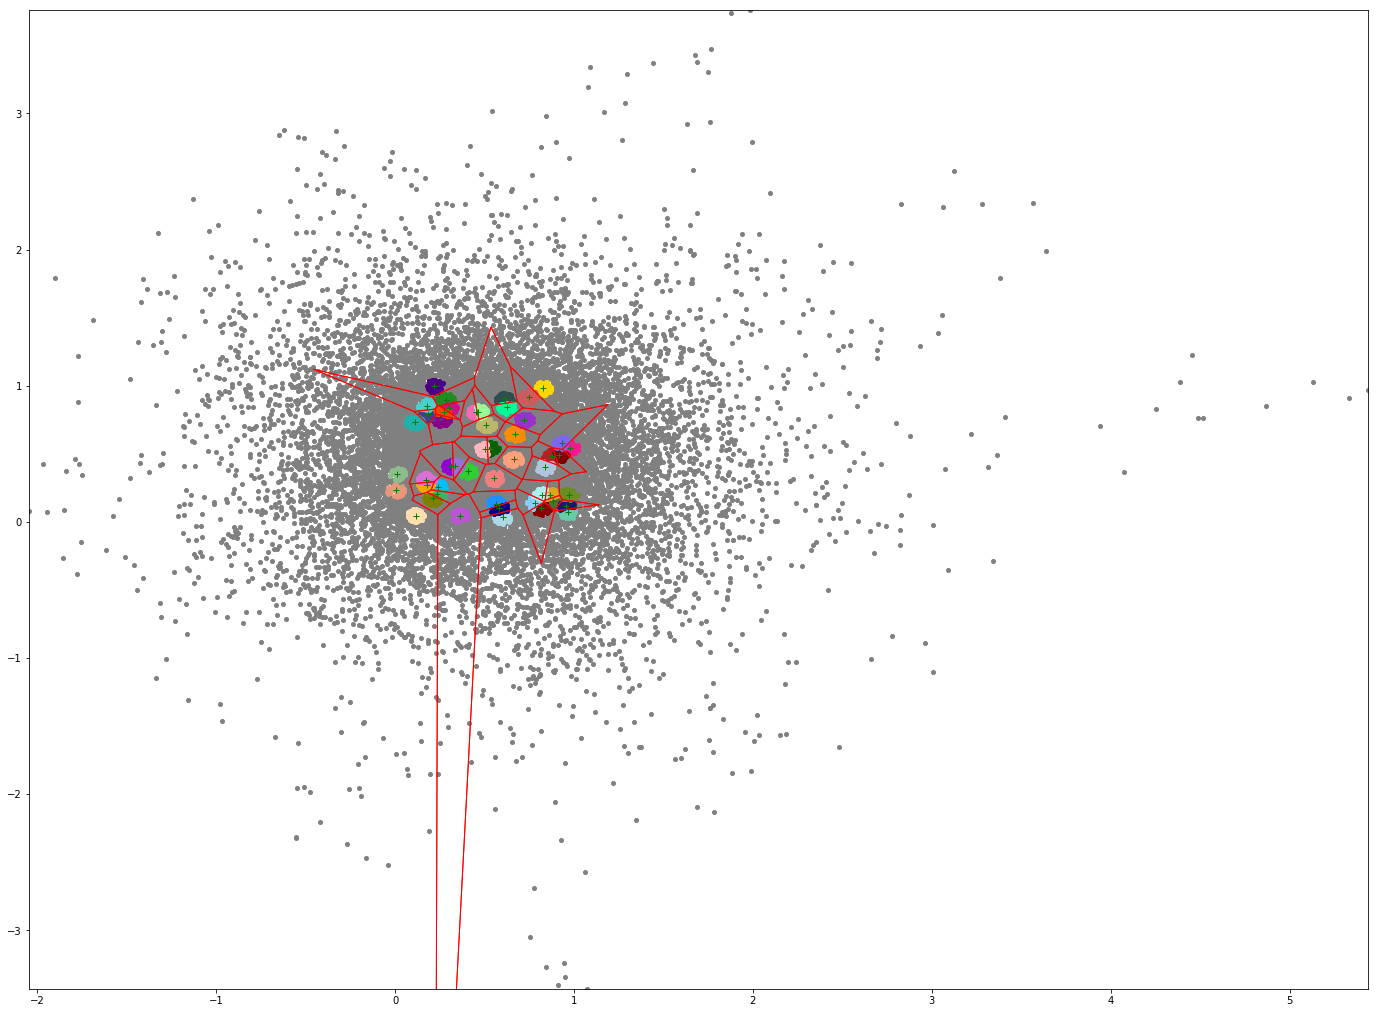

In [5]:
# plot the mesh from the rwa file

cell_plot(rwa_file, label=mesh_label)

In [ ]:
# step 3. infer D and V

t0 = time.time()

np.random.seed(seed)
infer(rwa_file, 'DV', max_iter=max_iter,
     localization_error=localization_error,
     diffusivity_prior=diffusivity_smoothing,
     potential_prior=potential_smoothing,
     jeffreys_prior=jeffreys_prior,
     input_label=mesh_label, output_label=maps_label)

# take a break

print('elapsed time: {:d}s'.format(round(time.time()-t0)))

In [ ]:
# plot the maps

map_plot(rwa_file, label=(mesh_label, maps_label), xlim=[0.,1.], ylim=[0.,1.])

# notes: the colour-coded map for the force is the log-amplitude
#
#        the current TRamWAy version does not properly draw the peripheral cells
#        that are open.